In [2]:
# # IMPORTS
# astronomy
from astropy.io import fits
# plotting 
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
# data 
import numpy as np
# my python files 
import match
import v2_AGN_DataAndPlotting as adp
import v2_SED as SED

# Get Data

In [3]:
def PrintNumber(myDict) :
    for key,val in myDict.items():
        if(isinstance(val,np.ndarray)):
            print(key,'\t',len(val)) 
        elif(isinstance(val,dict)):
            print(key,end='')
            for key1,val1 in val.items():
                print('\t',key1,'\t',len(val1))

In [4]:
# read AGN IDs
agnIDs = adp.ReadFile(adp.path_csv+'\\v2_AGNid_tricolor.csv')

# convert agnIDs into dict of integer numpy arrays 
agnIDs_dict = {
    'RED' : np.array(agnIDs[0], dtype=int),
    'GRN' : np.array(agnIDs[1], dtype=int),
    'BLU' : np.array(agnIDs[2], dtype=int)
}

# verify nmber of sources
PrintNumber(agnIDs_dict)

Cropped:  ['Row 1 = MIR exclusive AGN with id, redshift, and IRAC (n=472). Row 2 = MIR-X-ray inclusive AGN with id, redshift, and IRAC (n=663). Row 3 = X-ray exclusive AGN with id, redshift, and IRAC (n=1717). ']
RED 	 472
GRN 	 663
BLU 	 1717


In [5]:
# get redshifts
zDict = adp.ReadRedshifts(file=adp.path_cat+'\COSMOS_z_matches.csv')

Cropped:  ['ID', 'z']
Number of redshifts: 485793


In [6]:
agnInfo = {}
for key,val in agnIDs_dict.items():
    # match redshift to AGN
    key_zid, key_idz = match.match(zDict['ID'], val)
    agnInfo[key] = {
        'ID' : val[key_idz],
        'z'  : zDict['z'][key_zid]
    }
# verify number of sources
PrintNumber(agnInfo)

RED	 ID 	 472
	 z 	 472
GRN	 ID 	 663
	 z 	 663
BLU	 ID 	 1717
	 z 	 1717


In [7]:
# open COSMOS 2020 catalog file and get data 
with fits.open(adp.path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits') as hdul20:
    data20 = hdul20[1].data

# Prep SEDs

In [8]:
# get starting info 
Fnu_uJy = SED.GetPhotometry(data20, print=False)
IDs_all = SED.GetID(data20, print=False)
lam_A   = SED.GetObservedWavelengths_A(print=False)

In [9]:
for key,val in agnInfo.items():
    # match photometry to AGN
    key_agn, key_phot = match.match(val['ID'], IDs_all)
    # get phot
    Fnu = Fnu_uJy[key_phot]
    # get rest wavelength 
    lamR = SED.ConvertToRestWavelength(val['z'], print=False)
    # get energy density and normalize
    lamFlam = SED.ConvertToEnergyDensity(lamR, Fnu, print=False)
    lamFlam_norm = SED.NormalizeSED_1um(lamR, lamFlam, print=False)
    # get luminosity at 1um
    lum1um = SED.Lum_at1um(lamFlam, lamR, val['z'], )
    # append info
    val['Rest Wavelength'] = lamR
    val['Energy Density'] = lamFlam
    val['Energy Density Normalized at 1um'] = lamFlam_norm
    val['Luminosity at 1um'] = lum1um

# verify number of sources
PrintNumber(agnInfo)

RED	 ID 	 472
	 z 	 472
	 Rest Wavelength 	 472
	 Energy Density 	 472
	 Energy Density Normalized at 1um 	 472
	 Luminosity at 1um 	 472
GRN	 ID 	 663
	 z 	 663
	 Rest Wavelength 	 663
	 Energy Density 	 663
	 Energy Density Normalized at 1um 	 663
	 Luminosity at 1um 	 663
BLU	 ID 	 1717
	 z 	 1717
	 Rest Wavelength 	 1717
	 Energy Density 	 1717
	 Energy Density Normalized at 1um 	 1717
	 Luminosity at 1um 	 1717


In [10]:
def GetMaskOfRedshiftsInRange(z,minZ,maxZ):
    return( (z > minZ) & (z <= maxZ) )

def SplitAGNByZ(agnInfo) : 
    # initialize dict with redshift ranges 
    zRanges = [ (0,1),(1,1.5),(1.5,2),(2,3),(3,99) ]
    agnInfo_byZ = {
        '$0 < z \leq 1$'   : {},
        '$1 < z \leq 1.5$' : {},
        '$1.5 < z \leq 2$' : {},
        '$2 < z \leq 3$'   : {},
        '$3 < z \leq 6$'   : {}
    }
    # for each redshift range...
    i=0
    for zrange, agnAtZ in agnInfo_byZ.items() :
        # ... and each red/grn/blu...
        for color, dataDict in agnInfo.items() : 
            agnAtZ[color] = {}
            zmask = GetMaskOfRedshiftsInRange(dataDict['z'],zRanges[i][0],zRanges[i][1])
            # ... and each measurement ...
            for key,data in dataDict.items() : 
                # ... add only agn in this redshift range
                agnAtZ[color][key] = data[zmask]
        # increment to next redshift range 
        i+=1

    return(agnInfo_byZ)


agnInfo_byZ = SplitAGNByZ(agnInfo)

# SED shapes

In [11]:
print(agnInfo_byZ.keys())
print(agnInfo_byZ['$0 < z \\leq 1$'].keys())
print(agnInfo_byZ['$0 < z \\leq 1$']['RED'].keys())

dict_keys(['$0 < z \\leq 1$', '$1 < z \\leq 1.5$', '$1.5 < z \\leq 2$', '$2 < z \\leq 3$', '$3 < z \\leq 6$'])
dict_keys(['RED', 'GRN', 'BLU'])
dict_keys(['ID', 'z', 'Rest Wavelength', 'Energy Density', 'Energy Density Normalized at 1um', 'Luminosity at 1um'])


In [22]:
# get relevant data
panelData = {
    'RED' : {
        'x'     : agnInfo_byZ['$0 < z \\leq 1$']['RED']['Rest Wavelength'] * 1E-4,
        'y'     : agnInfo_byZ['$0 < z \\leq 1$']['RED']['Energy Density Normalized at 1um'] * 1E-4,
        'z'     : agnInfo_byZ['$0 < z \\leq 1$']['RED']['Luminosity at 1um'],
        'cmap'  : SED.GetCmap('r')
    },
    'GRN' : {
        'x'     : agnInfo_byZ['$0 < z \\leq 1$']['GRN']['Rest Wavelength'] * 1E-4,
        'y'     : agnInfo_byZ['$0 < z \\leq 1$']['GRN']['Energy Density Normalized at 1um'] * 1E-4,
        'z'     : agnInfo_byZ['$0 < z \\leq 1$']['GRN']['Luminosity at 1um'],
        'cmap'  : SED.GetCmap('g')
    },
    'BLU' : {
        'x'     : agnInfo_byZ['$0 < z \\leq 1$']['BLU']['Rest Wavelength'] * 1E-4,
        'y'     : agnInfo_byZ['$0 < z \\leq 1$']['BLU']['Energy Density Normalized at 1um'] * 1E-4,
        'z'     : agnInfo_byZ['$0 < z \\leq 1$']['BLU']['Luminosity at 1um'],
        'cmap'  : SED.GetCmap('b')
    }
}

In [23]:
# interpolate
for colorKey, data in panelData.items() :
    f_all = []
    for x,y in zip(data['x'],data['y']) : 
        f_all.append(SED.Interpolate_log(x,y))
    data['f(x)'] = f_all

In [24]:
# returns the interpolaterd slope between xi and xf for each function in f_arr
def GetSlopes(f_arr,xi,xf) : 
    # initialize array 
    m  = np.zeros(np.shape(f_arr))
    # calculate slope for each function 
    for i,f in enumerate(f_arr) : 
        yi = SED.Flog_X(f,xi)
        yf = SED.Flog_X(f,xf)
        m[i] = (np.log10(yf) - np.log10(yi)) / (np.log10(xf) - np.log10(xi))
    # return slope 
    return m

In [25]:
# get slope and boundary points 
for colorKey, data in panelData.items() : 
    data['Slopes'] = { 
        'UV'   : GetSlopes( data['f(x)'], 0.15, 1.00),
        'MIR1' : GetSlopes( data['f(x)'], 1.00, 6.50),
        'MIR2' : GetSlopes( data['f(x)'], 6.50, 10.0)
    }

In [26]:
# returns array containing the 5 panel slope T/F masks 
def SlopePanelMasks(uv_m,mir1_m,mir2_m) : 
    # create bin masks using slopes (m)
    b1 = (uv_m <  -0.3)                  & (mir1_m >= -0.2)
    b2 = (uv_m >= -0.3) & (uv_m <= 0.2)  & (mir1_m >= -0.2)
    b3 = (uv_m >   0.2)                  & (mir1_m >= -0.2)
    b4 = (uv_m >= -0.3)                  & (mir1_m <  -0.2) & (mir2_m >  0.0)
    b5 = (uv_m >= -0.3)                  & (mir1_m <  -0.2) & (mir2_m <= 0.0)
    # put masks in list
    panelMasks = np.array([b1,b2,b3,b4,b5])
    # return masks
    return panelMasks

In [27]:
# applied panel mask to x and y, then returns the result 
def PanelData(x,y,z,panelMasks) :
    # initialize lists 
    x_panel = []
    y_panel = [] 
    z_panel = []
    # bin 
    for mask in panelMasks :
        x_panel.append(x[mask])
        y_panel.append(y[mask])
        z_panel.append(z[mask])
    # return x and y panels
    return x_panel, y_panel, z_panel

In [28]:
# get panels
for colorKey, data in panelData.items() : 
    mask = SlopePanelMasks(data['Slopes']['UV'],data['Slopes']['MIR1'],data['Slopes']['MIR2'])
    data['xp'], data['yp'], data['zp'] = PanelData(data['x'], data['y'], data['z'], mask)

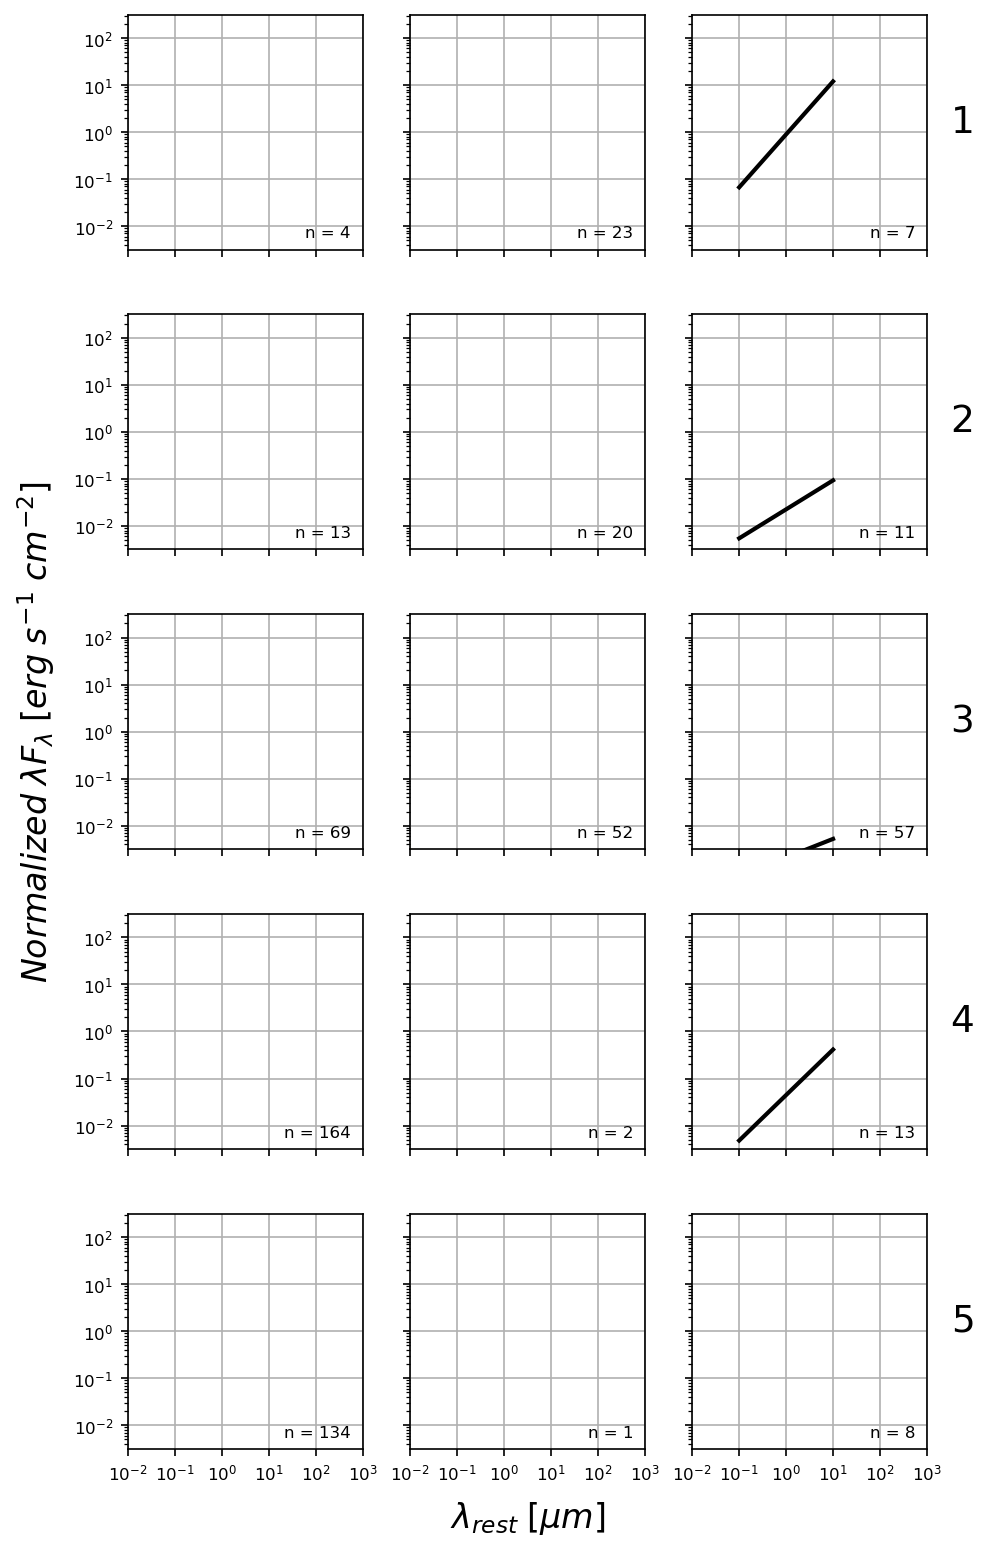

In [36]:
mosaic = [
        ["b1", "y1", "r1"],
        ["b2", "y2", "r2"],
        ["b3", "y3", "r3"],
        ["b4", "y4", "r4"],
        ["b5", "y5", "r5"]
    ]

adp.SetStyle()

fig = plt.figure(figsize=(6.5,10.5), constrained_layout=True)
ax_dict = fig.subplot_mosaic(
    mosaic, 
    sharex=True, 
    sharey=True
    )

# number of sources of a color 
r_n = len(panelData['RED']['x'])
g_n = len(panelData['GRN']['x'])
b_n = len(panelData['BLU']['x'])

for i in range(5) : 
    # get percent
    r_p = round(np.shape(panelData['RED']['xp'][i])[0] / r_n*100, 2)
    y_p = round(np.shape(panelData['GRN']['xp'][i])[0] / g_n*100, 2)
    b_p = round(np.shape(panelData['BLU']['xp'][i])[0] / b_n*100, 2)
    # plot
    SED.PlotSED_ax( ax_dict["r"+str(i+1)], panelData['RED']['xp'][i], panelData['RED']['yp'][i], z=panelData['RED']['zp'][i], cmap=panelData['RED']['cmap'],xLabel=False,yLabel=False)
    SED.PlotSED_ax( ax_dict["y"+str(i+1)], panelData['GRN']['xp'][i], panelData['GRN']['yp'][i], z=panelData['GRN']['zp'][i], cmap=panelData['GRN']['cmap'],xLabel=False,yLabel=False)
    SED.PlotSED_ax( ax_dict["b"+str(i+1)], panelData['BLU']['xp'][i], panelData['BLU']['yp'][i], z=panelData['BLU']['zp'][i], cmap=panelData['BLU']['cmap'],xLabel=False,yLabel=False)
    # panel label
    ax = ax_dict["r"+str(i+1)]
    ax.text(    1.15,                          # x
                0.50,                          # y 
                str(i+1),                      # string
                transform=ax.transAxes,        # use axis coordinants
                horizontalalignment='center',  # alignment 
                size=18
        )

# add axis lables 
ax_dict["b3"].set_ylabel('$Normalized \; \lambda F_{\lambda} \; [erg \; s^{-1} \; cm^{-2}]$', fontsize=fs)
ax_dict["y5"].set_xlabel('$\lambda_{rest} \; [\mu m]$', fontsize=fs)

plt.show()
plt.close()


# TODO fix sed curves not showing
# TODO add percent to each ax
# TODO add colorbar